
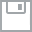
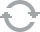
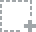
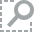
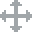
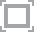
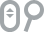
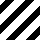
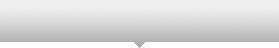
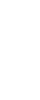
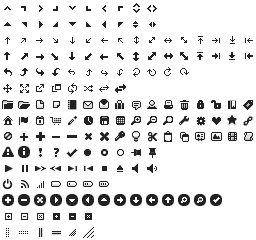
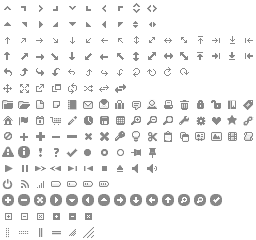
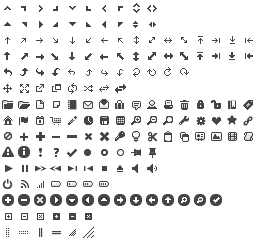
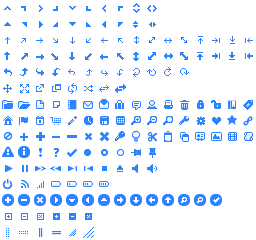
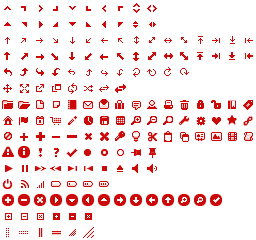
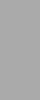
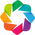
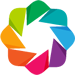

In [142]:
import glob
import os
import warnings
import sys
sys.path.append ('/Users/seinchin/Documents/Caltech/Bi 103/bebi103_utils')
# Our numerical workhorses
import numpy as np
import pandas as pd
from scipy.special import erf

# pickles are delicious
import pickle

# mcmc hammer
import emcee

# corner plots
import corner

# BE/Bi 103 utilities
import bebi103

# Image processing tools
import skimage
import skimage.io

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Import Bokeh modules for interactive plotting
import bokeh.charts
import bokeh.io
import bokeh.plotting

# Display graphics in this notebook
bokeh.io.output_notebook()

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Problem 7.2a 

We load the image stack, define an ROI, get the fluorescence in the ROI before bleaching, and then use that to normalize the fluorescence in the ROI after bleaching. I defined the ROIs by eye. The normalized fluorescences look fairly consistent, which gives some confidence in the ROIs identified. As examples, the first bleached frame from stack A and the ROI for stack H immediately after bleaching are shown. 

In [2]:
# Load in TIFF stacks
# The directory containing  data
data_dir = 'data/goehring_frap_data/'

# Glob string for images
im_glob = os.path.join(data_dir, '*.tif')

# Get list of files in directory
im_list = glob.glob(im_glob)
names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
ic = {}
for n, fname in zip(names,im_list):
    ic[n] = skimage.io.ImageCollection(fname, conserve_memory=False)[0]

In [165]:
verts_dict = {}
dx = 40.0 # pixels
dy = 40.0 # pixels
def display_image(key):
    skimage.io.imshow(ic[key][20,:,:])
    
def set_verts(key, x, y):
    verts_dict[key] = [(x,y), 
                      (x,y+40.0), 
                      (x+40.0, y+40.0), 
                      (x+40.0, y)]
    

/Applications/anaconda3/lib/python3.4/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image dynamic range; displaying image with stretched contrast.
  warnings.warn("Low image dynamic range; displaying image with "


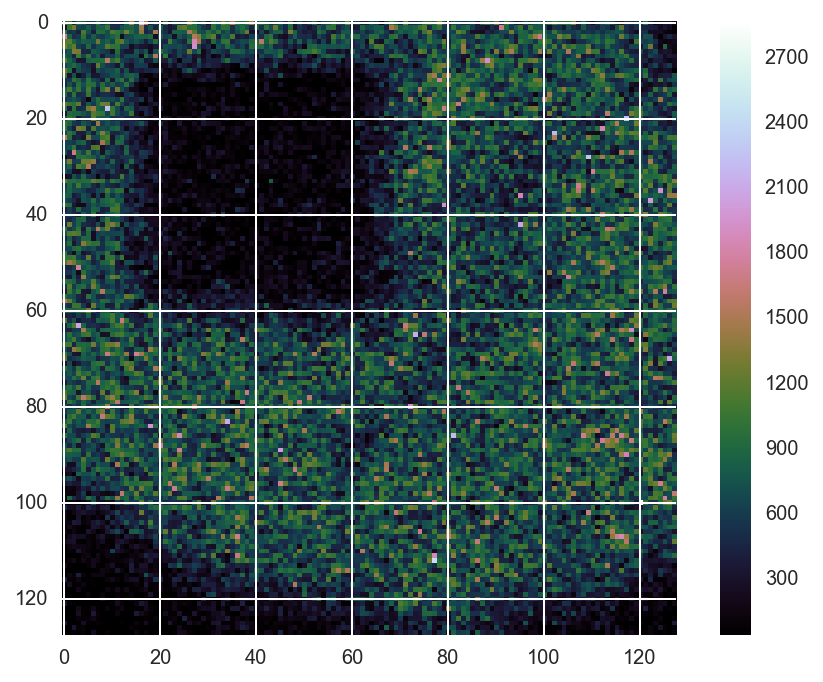

In [28]:
# first bleached frame is ic[20,:,:]
# need to get ROI from that frame
key = 'A'
display_image(key)

In [184]:
set_verts ('A', 20.0, 14.0)
set_verts('B',  45.0, 28.0)
set_verts('C',  50.0, 15.0)
set_verts('D',  60.0, 49.0)
set_verts('E',  20.0, 60.0)
set_verts('F',  17.0, 55.0)
set_verts('G',  17.0, 58.0)
set_verts('H',  23.0, 57.0)

/Applications/anaconda3/lib/python3.4/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image dynamic range; displaying image with stretched contrast.
  warnings.warn("Low image dynamic range; displaying image with "


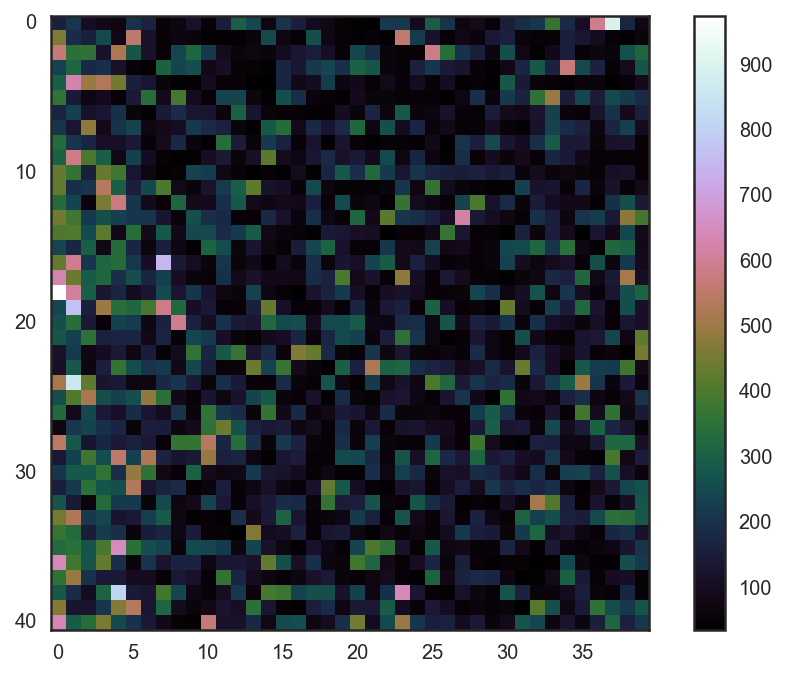

In [189]:
# Get cropped image and ROI within it (just show for image A)
ims = {}
rois = {}
for key in verts_dict.keys():
    _, rois[key], _ = bebi103.verts_to_roi(verts_dict[key], *ic[key][0].shape)


# Look at the image
with sns.axes_style('white'):
    key = 'H'
    skimage.io.imshow(ic[key][20,:,:][rois[key]])

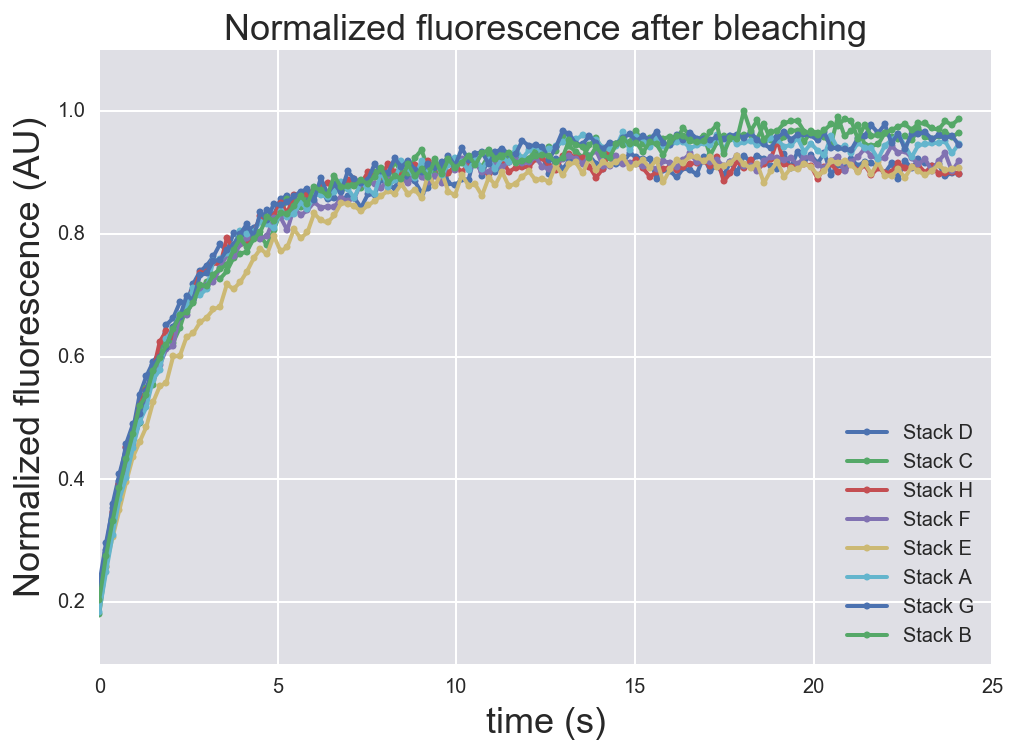

In [190]:
I_0s = {}
Is = {}
for key in rois.keys():
    I_0s[key] = np.mean(ic[key][19][rois[key]])
    Is[key] = np.array([np.mean(ic[key][i][rois[key]])/I_0s[key] \
                        for i in range(20,len(ic[key]))])
    ts = np.array([0.188*t for t in range(len(Is[key]))])
    plt.plot(ts, Is[key], '.-')
plt.xlabel('time (s)')
plt.ylabel('Normalized fluorescence (AU)')
plt.title('Normalized fluorescence after bleaching')
plt.legend (['Stack ' + k for k in rois.keys()], 
           loc='lower right')

## Problem 7.2b

First, we code functions for $\psi$ and the predicted normalized intensity. Using these and assuming that the measurements are Gaussian distributed with a mean defined by the predicted intensity and constant variance $\sigma^ 2$, we define a likelihood function. To fully define the posterior, we assume Jeffrey's priors on $K_{off}$ and $\sigma$ and uniform priors on $D$, $f_f$, and $f_b$. We use MCMC to sample the posterior for each stack and obtain the MAP estimates of each parameter for each stack. The posterior distributions are very smooth. One is plotted as an example. The others look similar. 

In [115]:
def psi(D, di, t):
    """
    psi_i of t
    """
    return di/2 * erf(di/np.sqrt(4*D*t)) - np.sqrt(D*t/np.pi) \
        * (1-np.exp(-di**2/4/D/t))

def I_norm (params, ts, ds):
    D, K_off, f_f, f_b = params
    dx, dy = ds
    psi_x = psi(D, dx, ts)
    psi_y = psi(D, dy, ts)
    return f_f * (1 - f_b*4*np.exp(-K_off*ts) / (dx*dy) * psi_x * psi_y)

In [120]:
def log_likelihood (params, ts, Is, ds):
    D, K_off, f_f, f_b, sigma = params
    predicted = I_norm ((D, K_off, f_f, f_b), ts, ds)
    sq_errors = (predicted - Is)**2
    n = len(ts)
    first = -sum(sq_errors)/2/sigma**2 
    second = -n*np.log(np.sqrt(2*np.pi*sigma**2))
    return first + second


def log_prior (params):
    D, K_off, f_f, f_b, sigma = params
    # check bounds
    log_p = 0
    if D < 0 or D > 500:
        return -np.inf
    else:
        log_p += -np.log(500)
    if K_off < 0 or K_off > 500:
        return -np.inf
    else:
        log_p += -np.log(K_off)
    if f_f < 0 or f_f > 1:
        return -np.inf
    else:
        log_p += 0
    if f_b < 0 or f_b > 1:
        return -np.inf
    else:
        log_p += 0
    if sigma < 0 or sigma > 10:
        return -np.inf
    else:
        log_p += -np.log(sigma)
        
    return log_p

def log_post(params, ts, Is, ds):
    l_prior = log_prior(params)
    if l_prior == -np.inf:
        return l_prior
    l_l = log_likelihood(params, ts, Is, ds)
    lp = l_prior + l_l
    if np.isnan(lp):
        print (params)
    return lp

def neg_log_post(params, ts, Is, ds):
    return -log_post(params, ts, Is, ds)


In [146]:
def do_mcmc(key):
    n_dim = 5        # number of parameters in the model (r and p)
    n_walkers = 50   # number of MCMC walkers
    n_burn = 500     # "burn-in" period to let chains stabilize
    n_steps = 5000   # number of MCMC steps to take after burn-in
    p0 = np.empty((n_walkers, n_dim))
    p0[:,0] = np.random.uniform(0, 500, n_walkers)            # D
    p0[:,1] = np.random.exponential(1.0, n_walkers)              # K_off
    p0[:,2] = np.random.uniform(0, 1, n_walkers)            # f_f
    p0[:,3] = np.random.uniform(0, 1, n_walkers)            # f_b
    p0[:,4] = np.random.exponential(1.0, n_walkers)              # sigma

    sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post, 
                                    args=(ts, Is[key], (dx,dy)))

    pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)
    _ = sampler.run_mcmc(pos, n_steps)
    return sampler



In [191]:
samplers = {}
for key in Is.keys():
    sampler = do_mcmc(key)
        
    # Get the index of the most probable parameter set
    max_ind = np.argmax(sampler.flatlnprobability)

    # Pull out values.
    D_MAP, K_MAP, f_f_MAP, f_b_map, sigma_map = sampler.flatchain[max_ind,:]
    # Print the results
    print("""
    Most probable parameter values for stack {4:s}:
    D:  {0:.3f} uM
    K_off: {1:.3f} s^-1
    f_f: {2:.3f}
    f_b: {3:.3f}
    """.format(D_MAP*0.138, K_MAP, f_f_MAP, f_b_map, key))
    samplers[key] = sampler


    Most probable parameter values for stack D:
    D:  1.999 uM
    K_off: 0.340 s^-1
    f_f: 0.913
    f_b: 0.784
    

    Most probable parameter values for stack C:
    D:  4.363 uM
    K_off: 0.178 s^-1
    f_f: 0.961
    f_b: 0.844
    

    Most probable parameter values for stack H:
    D:  0.563 uM
    K_off: 0.402 s^-1
    f_f: 0.913
    f_b: 0.779
    

    Most probable parameter values for stack F:
    D:  1.196 uM
    K_off: 0.313 s^-1
    f_f: 0.920
    f_b: 0.787
    

    Most probable parameter values for stack E:
    D:  0.903 uM
    K_off: 0.275 s^-1
    f_f: 0.911
    f_b: 0.792
    

    Most probable parameter values for stack A:
    D:  2.591 uM
    K_off: 0.255 s^-1
    f_f: 0.946
    f_b: 0.836
    

    Most probable parameter values for stack G:
    D:  2.031 uM
    K_off: 0.260 s^-1
    f_f: 0.956
    f_b: 0.780
    

    Most probable parameter values for stack B:
    D:  6.366 uM
    K_off: 0.121 s^-1
    f_f: 0.973
    f_b: 0.843
    


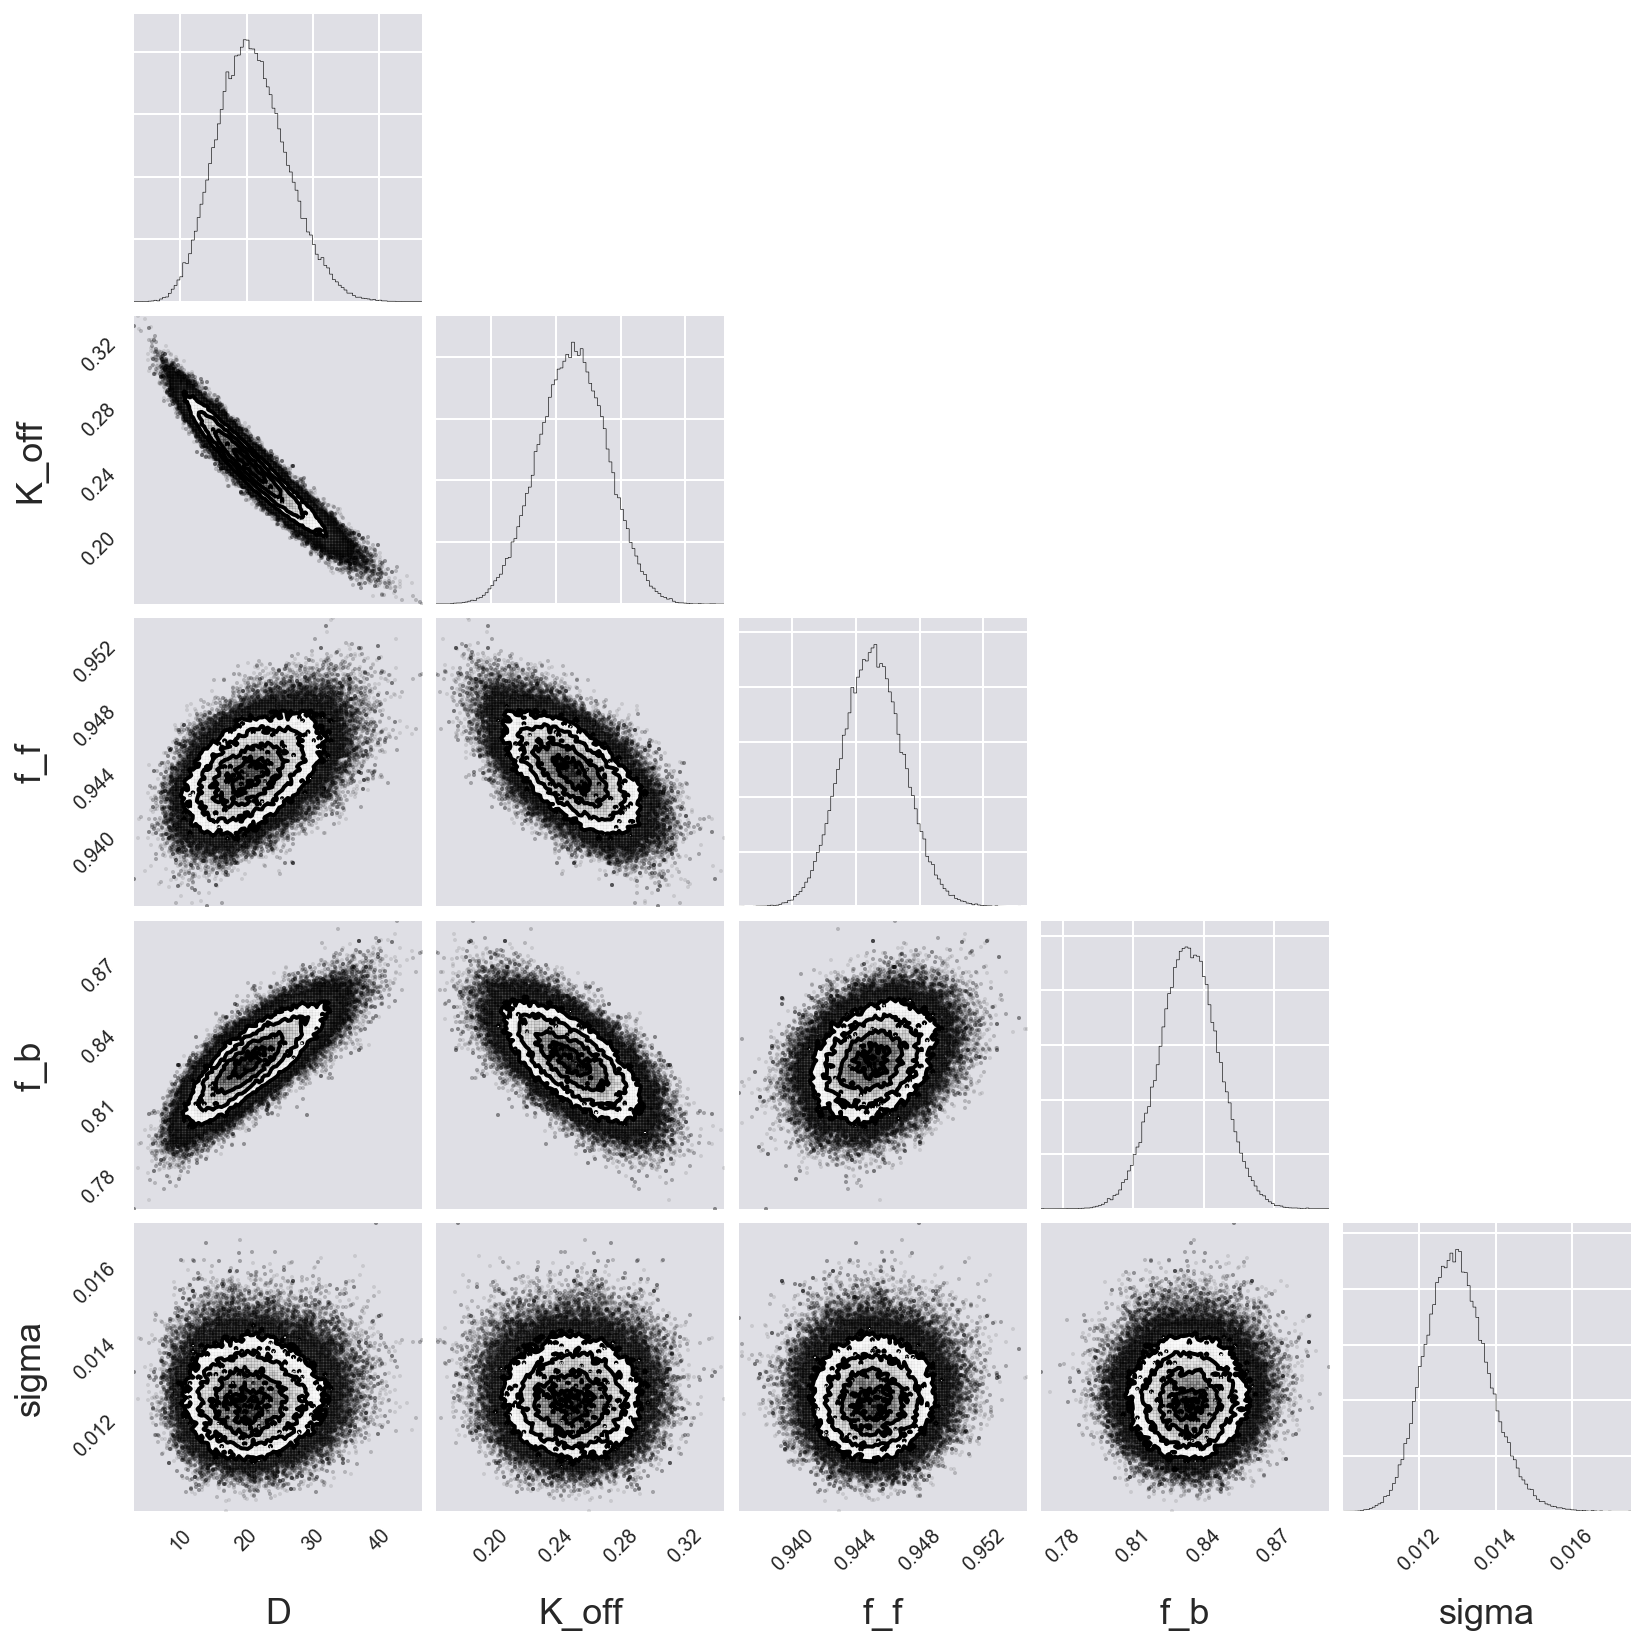

In [152]:
# with open ('Asampler.pkl') as f:
#     sampler = pickle.load(f)
fig = corner.corner(sampler.flatchain, labels=['D', 'K_off',
                                               'f_f', 'f_b', 'sigma'],
                    bins=100)

Above, we see the posterior distribution calculated from stack B. Below, we calculate the average values of $K_{off}$ and $D$ across the stacks. 

In [194]:
Ks = []
Ds = []
for key in Is.keys():
    sampler = samplers[key]
        
    # Get the index of the most probable parameter set
    max_ind = np.argmax(sampler.flatlnprobability)

    # Pull out values.
    D_MAP, K_MAP, f_f_MAP, f_b_map, sigma_map = sampler.flatchain[max_ind,:]
    Ds.append (D_MAP*0.138)
    Ks.append(K_MAP)

# Print the results
K_mean = sum(Ks)/len(Ks)
D_mean = sum(Ds)/len(Ds)
print("""
Average most probable parameter values:
D:  {0:.3f} uM
K_off: {1:.3f} s^-1
""".format(D_mean, K_mean))



Average most probable parameter values:
D:  2.501 uM
K_off: 0.268 s^-1

